In [1]:
#importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance
from ta import add_all_ta_features
import yfinance
from prophet import Prophet
import os
from ta import add_all_ta_features
import pickle

from sklearn.decomposition import PCA

%matplotlib inline

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

# Data Extraction
#symbols = [ "^NSEI","^NSEBANK" , "^CNXFMCG","NIFTY_FIN_SERVICE.NS","^CNXIT","NIFTY_PVT_BANK.NS","^CNXMETAL"]
# ["INR=X","^DJI","^DJI","^FTSE","BTC-USD","^VIX","RTY=F"]

symbol = "RTY=F"
#symbols = ["OLECTRA.NS","CONCOR.NS","ELGIEQUIP.NS","IOC.NS","BEL.NS","TATAELXSI.NS","^NSEI","HDFCBANK.NS","TATAMOTORS.NS","SBIN.NS",
#"TCS.NS","TITAN.NS","SUNPHARMA.BO","TECHM.NS", "ASIANPAINT.NS","TATACONSUM.NS"]

#df = pd.read_csv("./stock_historical_data/{}.csv".format(symbol))
df = yfinance.download (tickers = "{}".format(symbol),start="2007-03-06",
                            interval = "1d", group_by = 'ticker', auto_adjust = True)



df = df[["Open", "High", "Low", "Close","Volume"]]
df["Returns"] = df["Close"].pct_change()
df["Range"] = df["High"] / df["Low"] - 1
df["Avg_Range"] = df["Range"].rolling(window=30).mean()
df.tail()

def exponential_moving_average(data, window):
    if len(data) < window:
        raise ValueError("Data length should be greater than or equal to the window size.")
    
    alpha = 2 / (window + 1)
    ema = [data[0]]

    for i in range(1, len(data)):
        ema_value = alpha * data[i] + (1 - alpha) * ema[-1]
        ema.append(ema_value)
    return ema

[*********************100%***********************]  1 of 1 completed


In [3]:
#moving av
df['MA5'] = df.Close.rolling(window=5).mean()
df['EMA5'] = exponential_moving_average(df.Close.values,5)

df['MA10'] = df.Close.rolling(window=50).mean()
df['EMA10'] = exponential_moving_average(df.Close.values,10)

df['MA20'] = df.Close.rolling(window=20).mean()
df['EMA20'] = exponential_moving_average(df.Close.values,20)

df['MA50'] = df.Close.rolling(window=50).mean()
df['EMA50'] = exponential_moving_average(df.Close.values,50)

df['MA100'] = df.Close.rolling(window=100).mean()
df['EMA100'] = exponential_moving_average(df.Close.values,100)

#df['MA200'] =  df.Close.rolling(window=200).mean()
df.dropna(inplace=True)


In [4]:
#prophet
pro_df = df.copy()
pro_df["Date"] = pd.to_datetime(pro_df.index)
#renaming variables
pro_df = pro_df.rename(columns = {'Close': 'y',
                     'Date': 'ds'})
pro_df.reset_index()

pro_df.tail(10)


,Open,High,Low,y,Volume,Returns,Range,Avg_Range,MA5,EMA5,MA10,EMA10,MA20,EMA20,MA50,EMA50,MA100,EMA100,ds
Date,,,,,,,,,,,,,,,,,,,
2023-07-26,1980.199951,1999.500000,1972.300049,1991.900024,169516,0.007435,0.013791,0.016668,1979.559985,1981.147452,1871.539998,1969.370234,1937.675000,1943.518974,1871.539998,1891.981594,1827.351100,1861.142421,2023-07-26
2023-07-27,1987.599976,2012.699951,1958.099976,1966.199951,209790,-0.012902,0.027884,0.016999,1976.779980,1976.164952,1875.513997,1968.793819,1942.284998,1945.679067,1875.513997,1894.892118,1827.705099,1863.222768,2023-07-27
2023-07-28,1966.300049,1996.400024,1959.500000,1991.000000,158482,0.012613,0.018831,0.016767,1980.639990,1981.109968,1880.515996,1972.831306,1946.929999,1949.995346,1880.515996,1898.661054,1828.593099,1865.753010,2023-07-28
2023-07-31,1992.699951,2015.699951,1985.400024,2013.599976,171527,0.011351,0.015261,0.016641,1987.979980,1991.939970,1885.167996,1980.243792,1952.425000,1956.052930,1885.167996,1903.168463,1829.931099,1868.680673,2023-07-31
2023-08-01,2015.000000,2017.800049,1983.500000,2004.000000,172396,-0.004768,0.017293,0.016775,1993.339990,1995.959980,1889.425996,1984.563102,1957.070001,1960.619318,1889.425996,1907.122641,1831.168098,1871.360263,2023-08-01
2023-08-02,1994.500000,1999.300049,1966.000000,1976.599976,185261,-0.013673,0.016938,0.016853,1990.279980,1989.506645,1893.373997,1983.115261,1961.500000,1962.141285,1893.373997,1909.847242,1832.662098,1873.444218,2023-08-02
2023-08-03,1975.800049,1982.900024,1955.199951,1970.800049,164561,-0.002934,0.014167,0.016914,1991.200000,1983.271113,1896.771997,1980.876132,1967.225000,1962.965929,1896.771997,1912.237548,1834.643099,1875.372056,2023-08-03
2023-08-04,1969.699951,1987.699951,1958.699951,1965.500000,196355,-0.002689,0.014806,0.016944,1986.100000,1977.347409,1900.219998,1978.080471,1971.600000,1963.207269,1900.219998,1914.326272,1836.847100,1877.156768,2023-08-04
2023-08-07,1965.300049,1977.000000,1950.599976,1967.500000,142588,0.001018,0.013534,0.016720,1976.880005,1974.064939,1904.129998,1976.156749,1974.495001,1963.616101,1904.129998,1916.411516,1838.731100,1878.945743,2023-08-07


In [5]:
m = Prophet(
            #holidays = holidays,
            #seasonality_mode = 'multiplicative',
           # seasonality_prior_scale = 20,
            #changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(pro_df)
forecast = m.predict(pro_df)
forecast.head(5)

09:28:52 - cmdstanpy - INFO - Chain [1] start processing
09:28:53 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,1504.095110,1425.074189,1611.679000,1504.095110,1504.095110,16.122383,16.122383,16.122383,-0.705303,-0.705303,-0.705303,16.827686,16.827686,16.827686,0.0,0.0,0.0,1520.217494
1,2017-11-29,1504.788766,1425.627478,1608.723051,1504.788766,1504.788766,12.172752,12.172752,12.172752,-3.253041,-3.253041,-3.253041,15.425793,15.425793,15.425793,0.0,0.0,0.0,1516.961518
2,2017-11-30,1505.482422,1421.769171,1613.735107,1505.482422,1505.482422,10.274869,10.274869,10.274869,-3.586416,-3.586416,-3.586416,13.861285,13.861285,13.861285,0.0,0.0,0.0,1515.757291
3,2017-12-01,1506.176077,1421.140878,1603.192207,1506.176077,1506.176077,9.037042,9.037042,9.037042,-3.113983,-3.113983,-3.113983,12.151025,12.151025,12.151025,0.0,0.0,0.0,1515.213119
4,2017-12-04,1508.257044,1417.853644,1604.577701,1508.257044,1508.257044,3.818189,3.818189,3.818189,-2.542757,-2.542757,-2.542757,6.360946,6.360946,6.360946,0.0,0.0,0.0,1512.075233


In [6]:
forecast.tail()
with open('../../TrainedModel/fp_tech_indicator/{}.pkl'.format(symbol), 'wb') as f:
     pickle.dump(m, f)

In [7]:
#forecast["yearly"] = 0
#forecast["weekly"] = 0
forecast["ma20above50"] = 0
forecast["ma50above100"] = 0
forecast["ma20above100"] = 0
forecast["ma5"] = 0
forecast["ma10"] = 0
forecast["ma20"] = 0
forecast["ma50"] = 0
forecast["ma100"] = 0
forecast["ema5"] = 0
forecast["ema10"] = 0
forecast["ema20"] = 0
forecast["ema50"] = 0
forecast["ema100"] = 0
forecast["TARGET"] = 0


forecast["Close"] =  pro_df['y'].values

forecast["MA20"] =  pro_df['MA20'].values
forecast["MA100"] =  pro_df['MA100'].values
forecast["MA50"] =  pro_df['MA50'].values
forecast["MA5"] =  pro_df['MA5'].values
forecast["MA10"] =  pro_df['MA10'].values

forecast["EMA20"] =  pro_df['EMA20'].values
forecast["EMA100"] =  pro_df['EMA100'].values
forecast["EMA50"] =  pro_df['EMA50'].values
forecast["EMA5"] =  pro_df['EMA5'].values
forecast["EMA10"] =  pro_df['EMA10'].values
forecast.loc[forecast["Close"].shift(-1) > forecast["Close"],"TARGET"] = 1

forecast.loc[forecast["MA5"] < forecast["Close"],"ma5"] = 1
forecast.loc[forecast["EMA5"] < forecast["Close"],"ema5"] = 1

forecast.loc[forecast["MA10"] < forecast["Close"],"ema10"] = 1
forecast.loc[forecast["EMA10"] < forecast["Close"],"ema10"] = 1


forecast.loc[forecast["MA20"] < forecast["Close"],"ema20"] = 1
forecast.loc[forecast["EMA20"] < forecast["Close"],"ema20"] = 1

forecast.loc[forecast["MA50"] < forecast["Close"],"ema50"] = 1
forecast.loc[forecast["EMA50"] < forecast["Close"],"ema50"] = 1

forecast.loc[forecast["MA100"] < forecast["Close"],"ema100"] = 1
forecast.loc[forecast["EMA100"] < forecast["Close"],"ema100"] = 1




#forecast.loc[forecast["yearly"].shift(-1) > forecast["yearly"],"yearly"] = 1

#forecast.loc[forecast["weekly"].shift(-1) > forecast["weekly"],"weekly"] = 1

forecast.loc[forecast["MA20"] > forecast["MA50"],'ma20above50'] = 1
forecast.loc[forecast["MA50"] > forecast["MA100"],'ma50above100'] = 1
forecast.loc[forecast["MA20"] > forecast["MA100"],'ma20above100'] = 1

forecast.dropna(inplace=True)
#new_forecastdf.tail(10)
#forecast['Close'] = pro_df['y'].values
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,MA20,MA100,MA50,MA5,MA10,EMA20,EMA100,EMA50,EMA5,EMA10
0,2017-11-28,1504.095110,1425.074189,1611.679000,1504.095110,1504.095110,16.122383,16.122383,16.122383,-0.705303,...,1494.420007,1450.478201,1493.734006,1520.700024,1493.734006,1500.723220,1462.844816,1484.707292,1519.272690,1508.962431
1,2017-11-29,1504.788766,1425.627478,1608.723051,1504.788766,1504.788766,12.172752,12.172752,12.172752,-3.253041,...,1496.345007,1451.803201,1495.726006,1525.180005,1495.726006,1504.578147,1464.396403,1486.922690,1526.581777,1514.823798
2,2017-11-30,1505.482422,1421.769171,1613.735107,1505.482422,1505.482422,10.274869,10.274869,10.274869,-3.586416,...,1499.020007,1453.126201,1497.692007,1530.940015,1497.692007,1508.465945,1466.000435,1489.215919,1532.854526,1520.383112
3,2017-12-01,1506.176077,1421.140878,1603.192207,1506.176077,1506.176077,9.037042,9.037042,9.037042,-3.113983,...,1501.095007,1454.276201,1499.536006,1534.760010,1499.536006,1511.240615,1467.418248,1491.113333,1534.436343,1523.513451
4,2017-12-04,1508.257044,1417.853644,1604.577701,1508.257044,1508.257044,3.818189,3.818189,3.818189,-2.542757,...,1502.910004,1455.329200,1501.140005,1538.319995,1501.140005,1513.131982,1468.679272,1492.681436,1533.324220,1524.892819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,2023-08-02,1867.106049,1797.384509,1983.261700,1867.106049,1867.106049,25.371908,25.371908,25.371908,-3.253041,...,1961.500000,1832.662098,1893.373997,1990.279980,1893.373997,1962.141285,1873.444218,1909.847242,1989.506645,1983.115261
1428,2023-08-03,1867.243606,1805.224209,1986.669285,1867.243606,1867.243606,25.252550,25.252550,25.252550,-3.586416,...,1967.225000,1834.643099,1896.771997,1991.200000,1896.771997,1962.965929,1875.372056,1912.237548,1983.271113,1980.876132
1429,2023-08-04,1867.381164,1798.192009,1985.162942,1867.381164,1867.381164,25.854999,25.854999,25.854999,-3.113983,...,1971.600000,1836.847100,1900.219998,1986.100000,1900.219998,1963.207269,1877.156768,1914.326272,1977.347409,1978.080471
1430,2023-08-07,1867.793837,1803.802472,1981.572735,1867.793837,1867.793837,26.365777,26.365777,26.365777,-2.542757,...,1974.495001,1838.731100,1904.129998,1976.880005,1904.129998,1963.616101,1878.945743,1916.411516,1974.064939,1976.156749


In [8]:
new_df = forecast.copy()
#new_df
new_df1 = new_df[["TARGET","yearly","weekly","ma20above50","ma50above100","ma20above100","ma5","ma20","ma50","ma100","ema5","ema10","ema20","ema50","ema100"]]
new_df1
#new_df1.to_csv('data.csv')



,TARGET,yearly,weekly,ma20above50,ma50above100,ma20above100,ma5,ma20,ma50,ma100,ema5,ema10,ema20,ema50,ema100
0,1,16.827686,-0.705303,1,1,1,1,0,0,0,1,1,1,1,1
1,1,15.425793,-3.253041,1,1,1,1,0,0,0,1,1,1,1,1
2,0,13.861285,-3.586416,1,1,1,1,0,0,0,1,1,1,1,1
3,0,12.151025,-3.113983,1,1,1,1,0,0,0,1,1,1,1,1
4,0,6.360946,-2.542757,1,1,1,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,0,28.624950,-3.253041,1,1,1,0,0,0,0,0,1,1,1,1
1428,0,28.838965,-3.586416,1,1,1,0,0,0,0,0,1,1,1,1
1429,1,28.968982,-3.113983,1,1,1,0,0,0,0,0,1,1,1,1
1430,0,28.908534,-2.542757,1,1,1,0,0,0,0,0,1,1,1,1


In [9]:
#visulazation
import seaborn as sns


In [10]:
new_df1.describe()

,TARGET,yearly,weekly,ma20above50,ma50above100,ma20above100,ma5,ma20,ma50,ma100,ema5,ema10,ema20,ema50,ema100
count,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.0,1432.0,1432.0,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000
mean,0.530726,0.057373,-2.636131,0.603352,0.590084,0.583799,0.546788,0.0,0.0,0.0,0.561453,0.716480,0.625000,0.622207,0.625698
std,0.499229,32.540505,1.038039,0.489373,0.491990,0.493100,0.497980,0.0,0.0,0.0,0.496383,0.450864,0.484292,0.485005,0.484111
min,0.000000,-59.142240,-3.586416,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-25.069324,-3.253041,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.356565,-3.113983,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,22.821232,-2.542757,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,67.945271,-0.705303,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='ma50'>

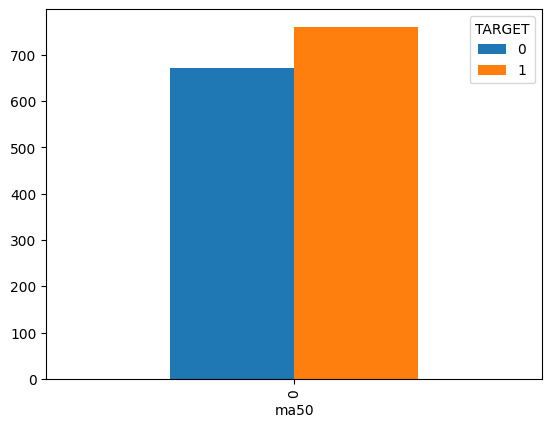

In [11]:
#sns.displot(x=new_df1["TARGET"],bins=3,kde=True)
#sns.boxplot(x=new_df1["yearly"])
#plt.pie(new_df1["ma20above100"].value_counts(),labels=new_df1["ma20above100"].value_counts().index)
#"yearly","weekly","ma20above50","ma50above100","ma20above100","ma5","ma20","ma50","ma100","ema5","ema10","ema20","ema50","ema100"
#sns.scatterplot(x=new_df1["weekly"],y=new_df1["TARGET"])
#sns.lmplot(data=new_df1,x="yearly",y="TARGET")
#sns.boxplot(x=new_df1["yearly"],y=new_df1["TARGET"])
ct = pd.crosstab(new_df1["ma50"],new_df1["TARGET"])
ct
ct.plot(kind="bar",stacked=False)